This notebook loads the trained models and metadata, selects the best model, retrains it on the full dataset, and exports it for deployment.

## Load Training Artifacts

In [1]:
import pickle
import json
from pathlib import Path
import toml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load configuration
config = toml.load('../config.toml')

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])
# Define paths
save_dir = Path('../data/processed')
artifacts_file = save_dir / '05_model_training_artifacts.pkl'
summary_file = save_dir / '05_model_training_summary.json'

# Load artifacts
with open(artifacts_file, 'rb') as f:
    training_artifacts = pickle.load(f)

with open(summary_file, 'r') as f:
    summary = json.load(f)

# Display loaded contents
print("Loaded training artifacts and summary.")
best_model_name = summary['best_model']
print(f"Best model: {best_model_name}")

Loaded training artifacts and summary.
Best model: lightgbm


## Prepare Final Dataset

In [2]:
# Load feature-selected data from previous step
with open(save_dir / '04_feature_selection.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']

print("Data loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Combine features
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

print(f"Full set shape: {X_full.shape}")
print(f"Full set labels: {y_full.shape}")

Data loaded successfully!
Training set shape: (137, 2095)
Test set shape: (35, 2095)
Full set shape: (172, 2095)
Full set labels: (172,)


## Re-encode Labels

In [3]:
from sklearn.preprocessing import LabelEncoder

# Use saved encoder or recreate
label_encoder = training_artifacts['label_info']['label_encoder']
if label_encoder is None:
    label_encoder = LabelEncoder()
    y_full_encoded = label_encoder.fit_transform(y_full)
else:
    y_full_encoded = label_encoder.transform(y_full)

## Retrain the Best Model

In [4]:
from sklearn.base import clone

# Get model config
best_model = training_artifacts['models'][best_model_name]
best_params = training_artifacts['training_config']['model_configs'][best_model_name]
selected_features = training_artifacts['feature_info']['feature_names'][best_model_name]

# Clone and configure the model
final_model = clone(best_model)
final_model.set_params(**best_params)

# Train on full data with selected features
final_model.fit(X_full[selected_features], y_full_encoded)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


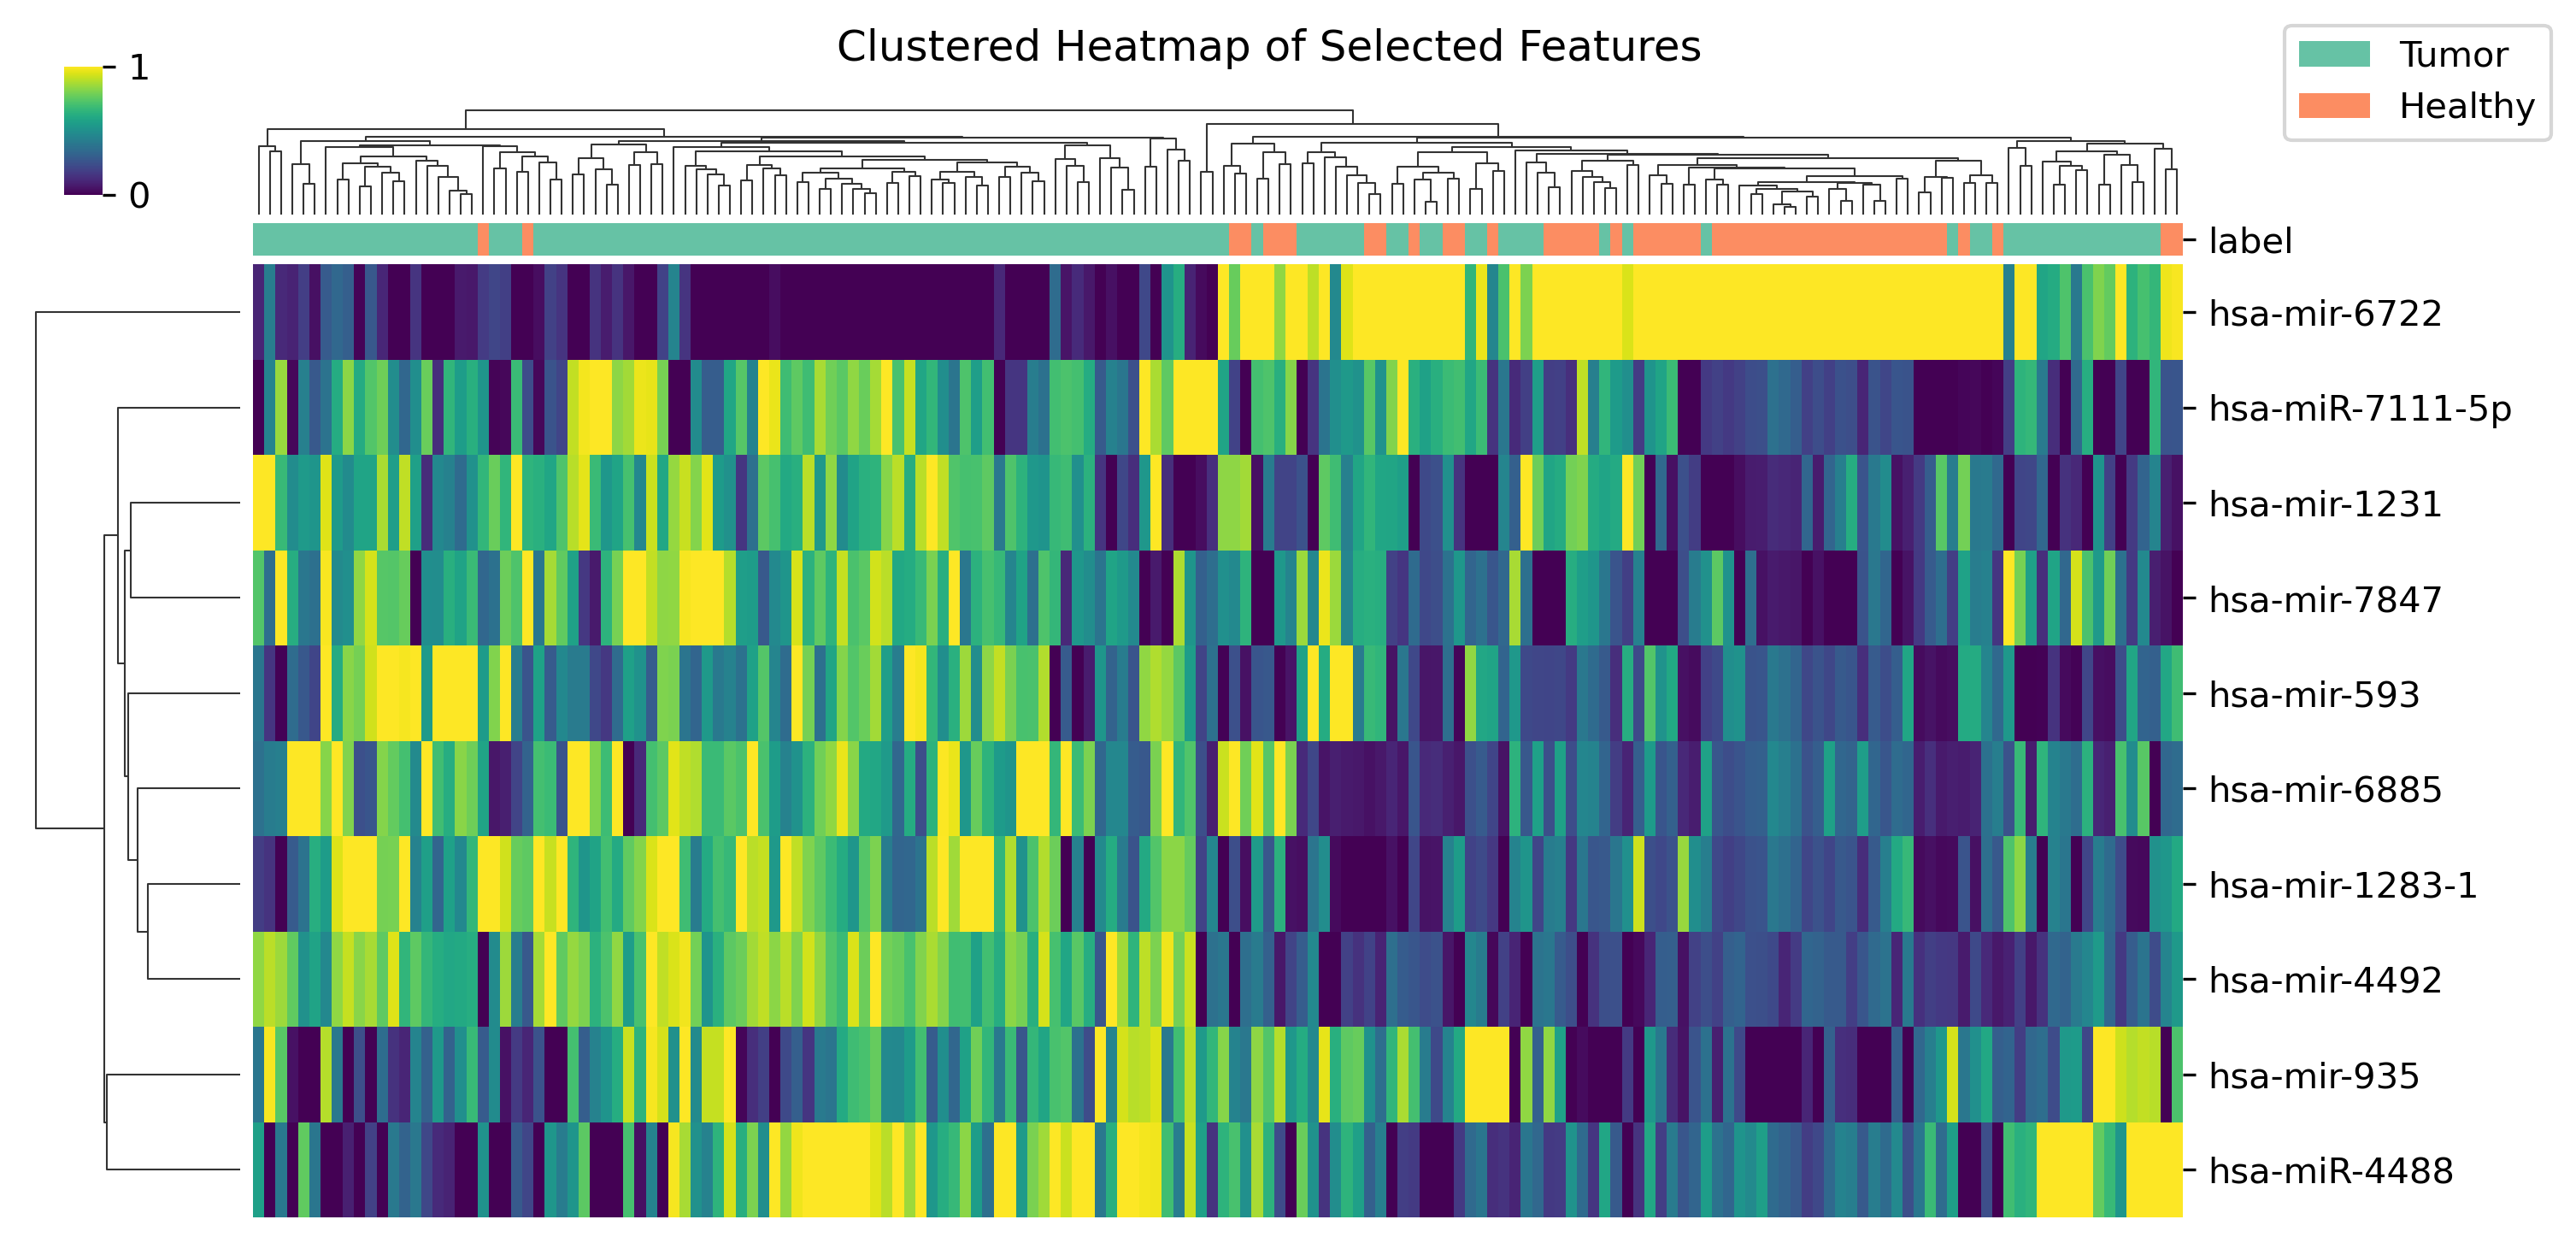

In [5]:
# Prepare data
data = X_full[selected_features]
labels = pd.Series(y_full).reset_index(drop=True)

# Map class labels to colors
palette = sns.color_palette("Set2", n_colors=labels.nunique())
label_to_color = dict(zip(labels.unique(), palette))
col_colors = labels.map(label_to_color)

# Plot clustered heatmap
g = sns.clustermap(data.T,
                   cmap='viridis',
                   figsize=(10, 5),
                   standard_scale=1,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=col_colors,              # ← annotate columns by y_train
                   dendrogram_ratio=(0.1, 0.1),       # ← shrink top dendrogram
                   cbar_pos=(0.03, 0.9, 0.015, 0.1))    # ← top-left, narrow & separated
# Hide x-axis ticks and labels
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xticklabels([])
# Fix title and layout
g.fig.suptitle("Clustered Heatmap of Selected Features", y=1.03)

# Optional: Add legend for labels
for label, color in label_to_color.items():
    g.ax_col_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="right", ncol=1, bbox_to_anchor=(1.2, 1.2))

plt.show()

## Save Final Model for Deployment

In [6]:
final_model_path = save_dir / f'final_model_{best_model_name}.pkl'
with open(final_model_path, 'wb') as f:
    pickle.dump({
        'model': final_model,
        'features': selected_features,
        'label_encoder': label_encoder,
        'classification_type': training_artifacts['label_info']['classification_type'],
        'classes': training_artifacts['label_info']['classes']
    }, f)

print(f"🎯 Final model saved to: {final_model_path}")

🎯 Final model saved to: ../data/processed/final_model_lightgbm.pkl


## Optional: Predict on New Data

In [7]:
# Example usage
# new_data = pd.read_csv('path_to_new_data.csv')
# predictions = final_model.predict(new_data[selected_features])
# decoded = label_encoder.inverse_transform(predictions)